In [1]:
!pip install numpyro

In [2]:
!pip install pymc==5.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.1/469.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import graphviz

In [4]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [5]:
#combine
all_data = pd.concat((raw22, raw21, raw20))

del raw22
del raw21
del raw20

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#define hit direction type
all_data['is_oppo'] = 0
all_data.loc[all_data.hit_direction > 0, 'is_oppo'] = 1
all_data['is_pull'] = 1-all_data.is_oppo.values

all_data['is_pull2'] = 0
all_data.loc[all_data.hit_direction <= -15, 'is_pull2'] = 1
all_data['is_mid'] = 0
all_data.loc[(all_data.hit_direction > -15) & (all_data.hit_direction < 15), 'is_mid'] = 1
all_data['is_oppo2'] = 0
all_data.loc[all_data.hit_direction >= 15, 'is_oppo2'] = 1

all_data['hittype'] = 0
all_data.loc[all_data.is_mid == 1, 'hittype'] = 1
all_data.loc[all_data.is_oppo2 == 1, 'hittype'] = 2

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'hd', 'is_oppo', 'is_pull', 'is_pull2', 'is_mid', 'is_oppo2', 'hittype']]

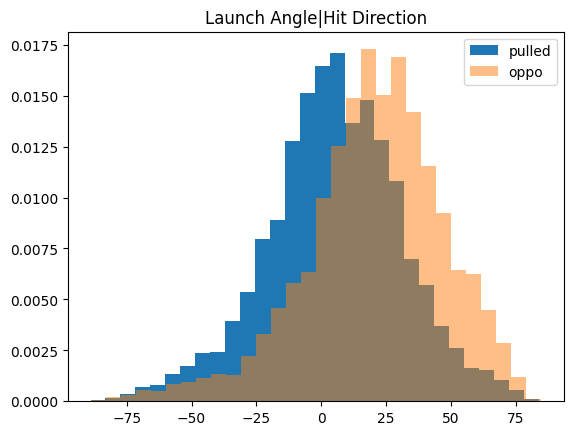

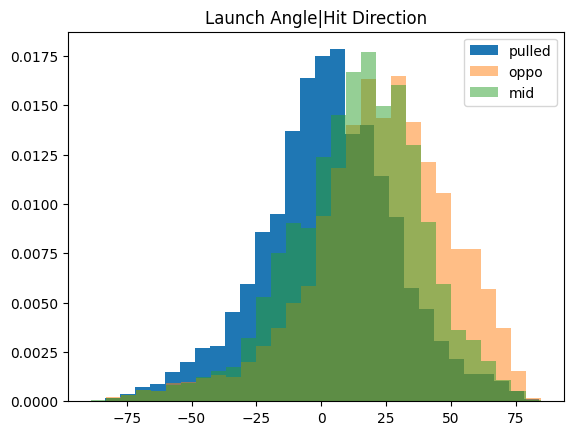

In [6]:

plt.hist(all_data.loc[all_data.is_pull == 1].launch_angle.values, density = True, bins = 30, label = 'pulled')
plt.hist(all_data.loc[all_data.is_oppo ==1].launch_angle.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
plt.legend()
plt.title('Launch Angle|Hit Direction')
plt.show()

plt.hist(all_data.loc[all_data.is_pull2 == 1].launch_angle.values, density = True, bins = 30, label = 'pulled')
plt.hist(all_data.loc[all_data.is_oppo2 == 1].launch_angle.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
plt.hist(all_data.loc[all_data.is_mid == 1].launch_angle.values, density = True, bins = 30, label = 'mid', alpha = 0.5)
plt.legend()
plt.title('Launch Angle|Hit Direction')
plt.show()

In [7]:
#train test split
train,test = train_test_split(all_data, train_size = 0.7, random_state = 42)

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(train.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

train = train.merge(batter_indices, on = 'batter_id_hand')
test = test.merge(batter_indices, on = 'batter_id_hand', how = 'inner')

### **Model 1:** normals for pull and oppo

In [8]:
#get a prior for the hitter average launch angle
hitter_avgs = train.groupby(['batter_index', 'is_pull', 'is_oppo'], as_index = False).agg(N = ('launch_angle', 'count'),la = ('launch_angle', 'mean'))
#make sure we have a reasonable sample size
hitter_avgs = hitter_avgs.loc[hitter_avgs.N >= 50]
hitter_avgs.loc[hitter_avgs.is_pull == 1].la.mean(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.mean(), hitter_avgs.loc[hitter_avgs.is_pull == 1].la.std(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.std()

(5.1136665465915945, 20.971604422179492, 5.151637108497688, 5.690627494393088)

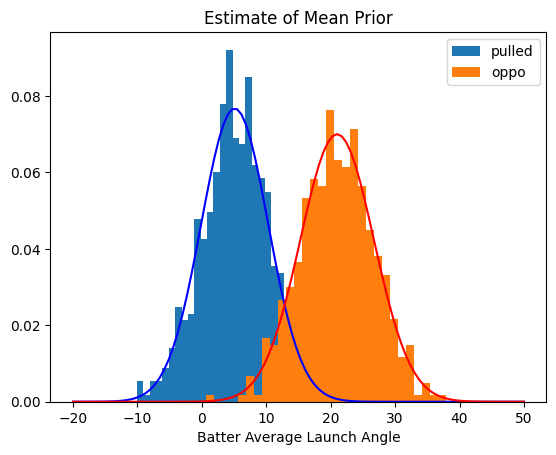

In [9]:
x = np.linspace(-20,50,100)
plt.hist(hitter_avgs.loc[hitter_avgs.is_pull == 1].la.values, density = True, bins = 30, label = 'pulled')
plt.plot(x, norm(loc = 5.1, scale = 5.2).pdf(x), 'b-')
plt.hist(hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.values, density = True, bins = 30, label = 'oppo')
plt.plot(x, norm(loc = 21, scale = 5.7).pdf(x), 'r-')
plt.title('Estimate of Mean Prior')
plt.xlabel('Batter Average Launch Angle')
plt.legend()
plt.show()

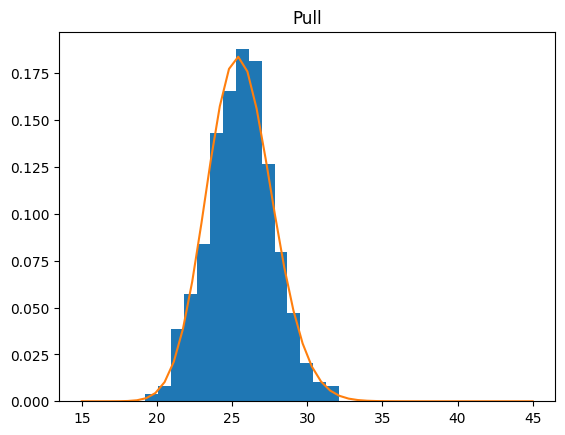

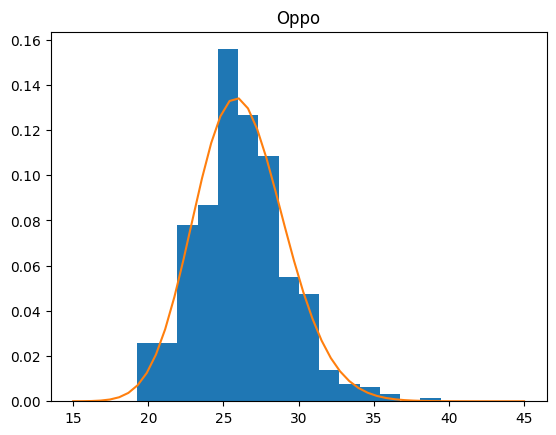

In [11]:
hitter_stds = train.groupby(['batter_index', 'is_pull', 'is_oppo'], as_index = False).agg(n = ('launch_angle', 'count'),la = ('launch_angle', 'std'))
hitter_stds = hitter_stds.loc[hitter_stds.n >= 50]
a1,_, scale1 = gamma.fit(hitter_stds.loc[hitter_stds.is_pull == 1].la.values, floc = 0)
a2,_, scale2 = gamma.fit(hitter_stds.loc[hitter_stds.is_oppo == 1].la.values, floc = 0)
x = np.linspace(15, 45)
plt.hist(hitter_stds.loc[hitter_stds.is_pull == 1].la.values, density = True, bins = 15)
plt.plot(x, gamma(a = a1, scale = scale1).pdf(x), '-')
plt.title('Pull')
plt.show()
plt.hist(hitter_stds.loc[hitter_stds.is_oppo == 1].la.values, density = True, bins = 15)
plt.plot(x, gamma(a = a2, scale = scale2).pdf(x), '-')
plt.title('Oppo')
plt.show()

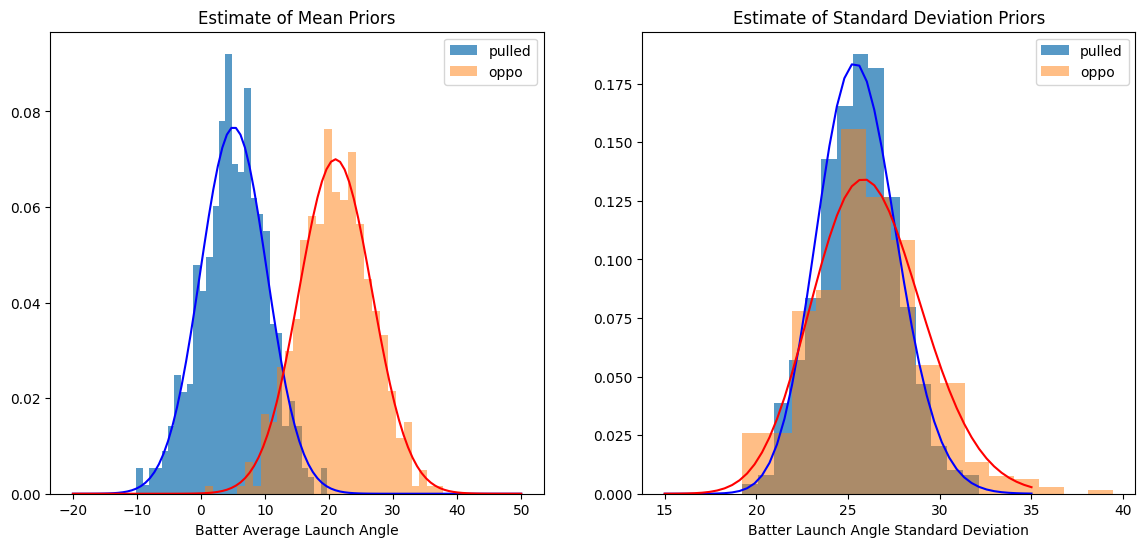

In [14]:
x = np.linspace(-20,50,100)
plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.hist(hitter_avgs.loc[hitter_avgs.is_pull == 1].la.values, density = True, bins = 30, label = 'pulled', alpha = 0.75)
ax1.plot(x, norm(loc = 5.1, scale = 5.2).pdf(x), 'b-')
ax1.hist(hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.values, density = True, bins = 30, label = 'oppo', alpha = 0.5)
ax1.plot(x, norm(loc = 21, scale = 5.7).pdf(x), 'r-')
ax1.set_title('Estimate of Mean Priors')
ax1.set_xlabel('Batter Average Launch Angle')
ax1.legend()

x = np.linspace(15, 35)
ax2 = plt.subplot(122)
ax2.hist(hitter_stds.loc[hitter_stds.is_pull == 1].la.values, density = True, bins = 15, label = 'pulled', alpha = 0.75)
ax2.plot(x, gamma(a = a1, scale = scale1).pdf(x), 'b-')
ax2.hist(hitter_stds.loc[hitter_stds.is_oppo == 1].la.values, density = True, bins = 15, label = 'oppo', alpha = 0.5)
ax2.plot(x, gamma(a = a2, scale = scale2).pdf(x), 'r-')
ax2.set_title('Estimate of Standard Deviation Priors')
ax2.legend()
ax2.set_xlabel('Batter Launch Angle Standard Deviation')
plt.show()

In [15]:
#pymc uses beta, which is 1/scale
a1, scale1, 1/scale1, a2, scale2, 1/scale2

(137.8532596493912,
 0.18540319458875004,
 5.393650320956651,
 76.7651823519339,
 0.3409756972890713,
 2.9327603343889437)

In [16]:
#build the model
n_batters = len(train.batter_index.unique())
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'hit_type': [0,1]} #hit type corresponds to is_oppo in this case
#define the prior for the batter means
langle_means = np.array([hitter_avgs.loc[hitter_avgs.is_pull == 1].la.mean(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.mean()])
langle_sigma = np.array([hitter_avgs.loc[hitter_avgs.is_pull == 1].la.std(), hitter_avgs.loc[hitter_avgs.is_oppo == 1].la.std()])
alpha_prior = np.array([a1, a2])
beta_prior = np.array([1/scale1, 1/scale2])

with pm.Model(coords = coords) as mod1:
    #the batter means have normal priors
    battermeans = pm.Normal('battermeans', mu = langle_means, sigma = langle_sigma, dims = ('batter', 'hit_type'))

    #the batter sigmas have gamma priors
    battersigmas = pm.Gamma('battersigmas', alpha = alpha_prior, beta = beta_prior, dims = ('batter', 'hit_type'))

    #the likelihoods are normally distributed based on if it's pull or oppo
    ht = pm.Data('ht', train.is_oppo.values, dims = 'observation')
    b = pm.Data('b', train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.launch_angle.values, dims = 'observation')
    likelihood = pm.Normal('likelihood', mu = battermeans[b, ht], sigma = battersigmas[b, ht], observed = x, dims = 'observation')

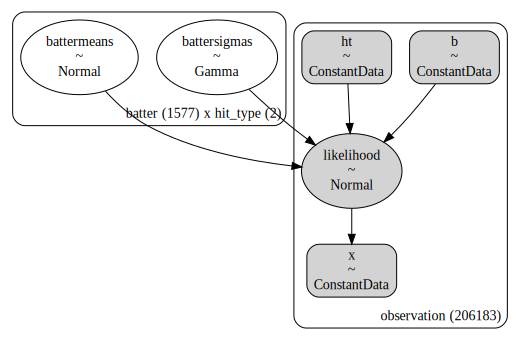

In [17]:
graph = pm.model_to_graphviz(mod1)
graph

In [18]:
with mod1:
    trace = pmjax.sample_numpyro_nuts(2000,chains=1, random_seed=42)

Compiling...
Compilation time =  0:00:09.565925
Sampling...


sample: 100%|██████████| 3000/3000 [02:17<00:00, 21.77it/s, 31 steps of size 1.86e-01. acc. prob=0.82]


Sampling time =  0:02:23.535126
Transforming variables...
Transformation time =  0:00:00.273957


In [ ]:
#with mod1:
#    inference = pm.ADVI()
#    approx = pm.fit(n=20000, method = inference)

In [ ]:
#plt.plot(inference.hist, label = 'advi')
#plt.show()

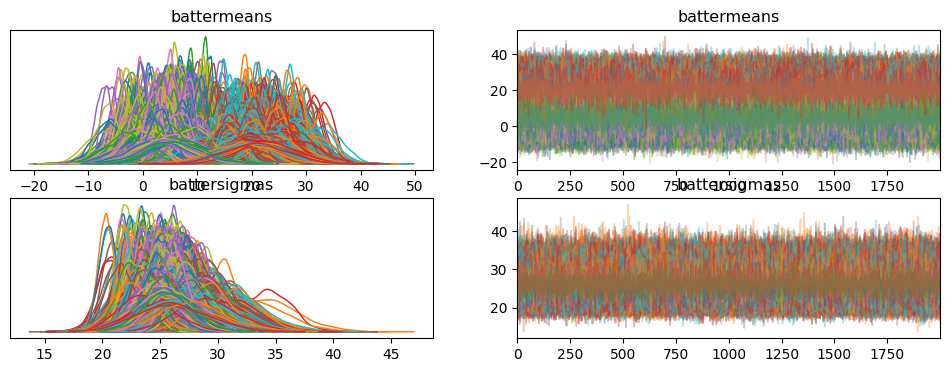

In [19]:
#trace = approx.sample(2000)
az.plot_trace(trace)
plt.show()

In [20]:
#calculate the likelihoods of the data in both the training and testing set using the posteriors we just calculated
bmeans = trace.posterior.battermeans.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_mean_pull', 'batter_mean_oppo']] = bmeans
bsigmas = trace.posterior.battersigmas.mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_sigma_pull', 'batter_sigma_oppo']] = bsigmas

train = train.merge(batter_indices[['batter_index', 'batter_mean_pull', 'batter_mean_oppo', 'batter_sigma_pull', 'batter_sigma_oppo']], on = 'batter_index')
test = test.merge(batter_indices[['batter_index', 'batter_mean_pull', 'batter_mean_oppo', 'batter_sigma_pull', 'batter_sigma_oppo']], on = 'batter_index')

In [21]:
train['log_like'] = train.is_pull.values * norm(loc = train.batter_mean_pull.values, scale = train.batter_sigma_pull.values).logpdf(train.launch_angle.values) + train.is_oppo.values * norm(loc = train.batter_mean_oppo.values, scale = train.batter_sigma_oppo.values).logpdf(train.launch_angle.values)
test['log_like'] = test.is_oppo.values * norm(loc = test.batter_mean_oppo.values, scale = test.batter_sigma_oppo.values).logpdf(test.launch_angle.values) + test.is_pull.values * norm(loc = test.batter_mean_pull.values, scale = test.batter_sigma_pull.values).logpdf(test.launch_angle.values)

In [22]:
train.log_like.mean(), test.log_like.mean()

(-4.659211027337951, -4.673251661417575)

In [ ]:
train.log_like.mean(), test.log_like.mean()

(-4.654945014407268, -4.673294271779149)

In [ ]:
train.log_like.mean(), test.log_like.mean()

(-4.664053087651965, -4.676306977970614)

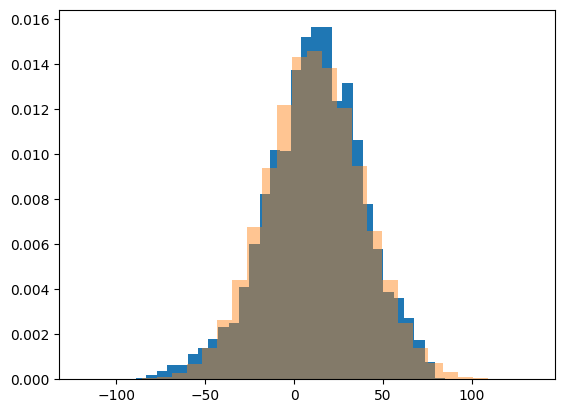

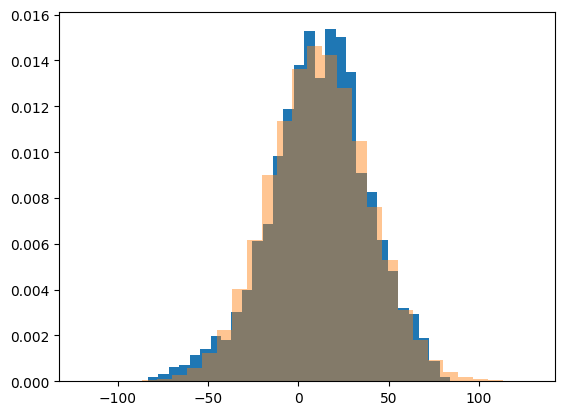

In [23]:
#draw samples
samp = train.is_oppo.values * norm(loc = train.batter_mean_oppo.values, scale = train.batter_sigma_oppo.values).rvs() + train.is_pull.values * norm(loc = train.batter_mean_pull.values, scale = train.batter_sigma_pull.values).rvs()
plt.hist(train.launch_angle.values, density = True, bins = 30)
plt.hist(samp, density = True, bins = 30, alpha = 0.45)
plt.show()

samp = test.is_oppo.values * norm(loc = test.batter_mean_oppo.values, scale = test.batter_sigma_oppo.values).rvs() + test.is_pull.values * norm(loc = test.batter_mean_pull.values, scale = test.batter_sigma_pull.values).rvs()
plt.hist(test.launch_angle.values, density = True, bins = 30)
plt.hist(samp, density = True, bins = 30, alpha = 0.45)
plt.show()

### **QQ Plots**

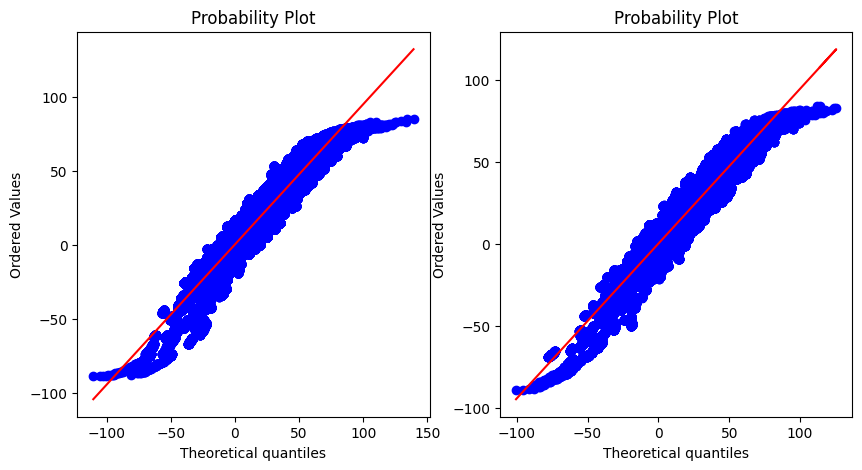

In [24]:
#QQ plots
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
probplot(train.launch_angle.values, dist = norm(loc = train.is_pull.values * train.batter_mean_pull.values + train.is_oppo.values * train.batter_mean_oppo.values, scale = train.is_pull.values * train.batter_sigma_pull.values + train.is_oppo.values * train.batter_sigma_oppo.values), plot = ax1)
probplot(test.launch_angle.values, dist = norm(loc = test.is_pull.values * test.batter_mean_pull.values + test.is_oppo.values * test.batter_mean_oppo.values, scale = test.is_pull.values * test.batter_sigma_pull.values + test.is_oppo.values * test.batter_sigma_oppo.values), plot = ax2)
plt.show()

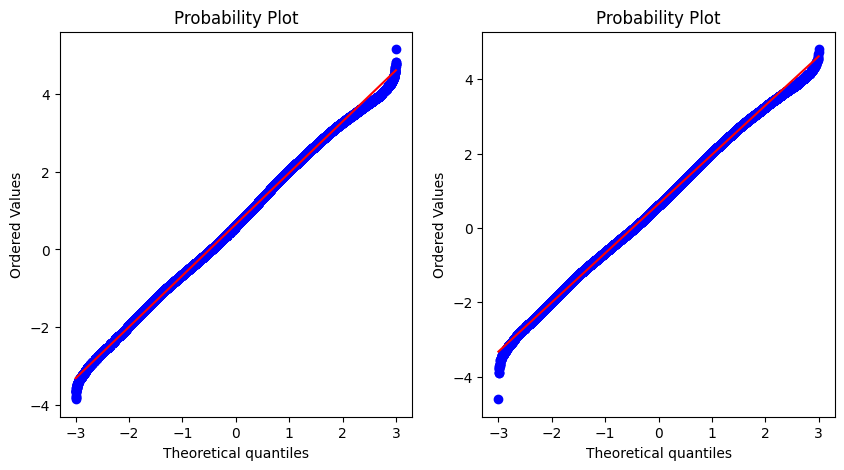

In [25]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
train['z'] = (train.launch_angle.values - train.is_pull.values * train.batter_mean_pull.values + train.is_oppo.values * train.batter_mean_oppo.values) / (train.is_pull.values * train.batter_sigma_pull.values + train.is_oppo.values * train.batter_sigma_oppo.values)
test['z'] = (test.launch_angle.values - test.is_pull.values * test.batter_mean_pull.values + test.is_oppo.values * test.batter_mean_oppo.values) / (test.is_pull.values * test.batter_sigma_pull.values + test.is_oppo.values * test.batter_sigma_oppo.values)
probplot(train.z.values, dist = truncnorm(a=-3,b=3), plot = ax1)
probplot(test.z.values, dist = truncnorm(a=-3,b=3), plot = ax2)
plt.show()

In [26]:
def custom_qq_plot(dataframe):
    dataframe = dataframe.sort_values('batter_index')
    #get the quantiles for each point in the data
    for b in batter_indices.batter_index.values:
        for ht in [0,1]:
            d = dataframe.loc[(dataframe.batter_index == b) & (dataframe.is_oppo == ht)]
            nts = [np.mean(i >= d.launch_angle.values) for i in d.launch_angle.values]
            ntiles = np.array(nts)
            #calculate the quantiles for each of those points given the true posterior distribution
            actual_quantiles = d.is_oppo.values * norm(loc = d.batter_mean_oppo.values, scale = d.batter_sigma_oppo.values).ppf(ntiles) + d.is_pull.values * norm(loc = d.batter_mean_pull.values, scale = d.batter_sigma_pull.values).ppf(ntiles)

            plt.plot(actual_quantiles, d.launch_angle.values, 'k.')
    plt.plot([-100,100],[-100,100], 'r-')
    plt.xlabel('Theoretical Quantile')
    plt.ylabel('Empirical Quantile')
    plt.title('QQ plot')
    plt.show()

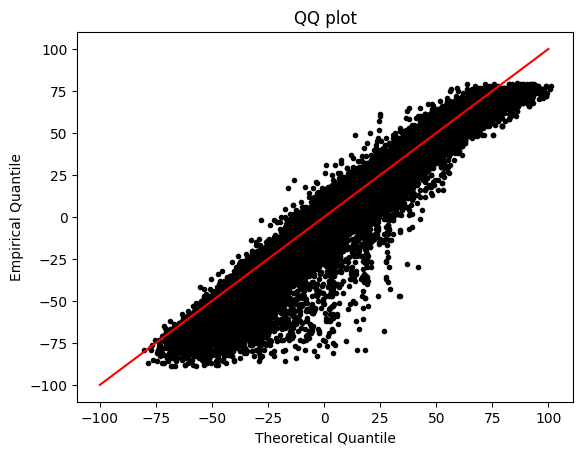

In [27]:
custom_qq_plot(train)

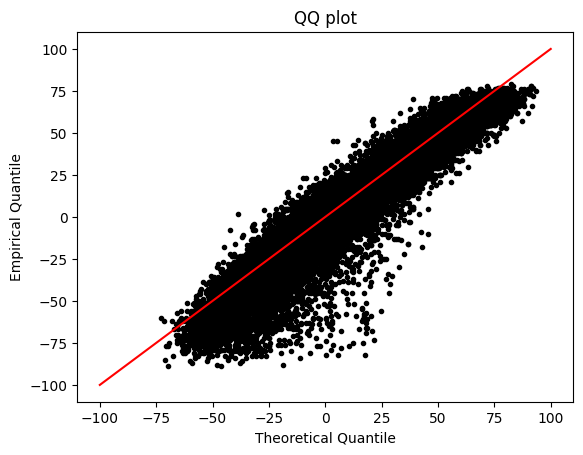

In [28]:
custom_qq_plot(test)

### **PP Plot**

In [29]:
def pp_plot(dataframe):
    dataframe = dataframe.sort_values(['batter_index', 'is_oppo'])
    #get the ntiles for each point in the data
    ntiles = []
    for b in batter_indices.batter_index.values:
        for ht in [0,1]:
            d = dataframe.loc[(dataframe.batter_index == b) & (dataframe.is_oppo == ht)]
            nts = np.array([np.mean(i >= d.launch_angle.values) for i in d.launch_angle.values])
            actual_ntiles = d.is_oppo.values * norm(loc = d.batter_mean_oppo.values, scale = d.batter_sigma_oppo.values).cdf(d.launch_angle.values) + d.is_pull.values * norm(loc = d.batter_mean_pull.values, scale = d.batter_sigma_pull.values).cdf(d.launch_angle.values)
            plt.plot(nts,actual_ntiles, 'k.')
    plt.plot([0,1],[0,1], 'r-')
    plt.xlabel('empirical cdf')
    plt.ylabel('theoretical cdf')
    plt.title('PP Plot')
    plt.show()

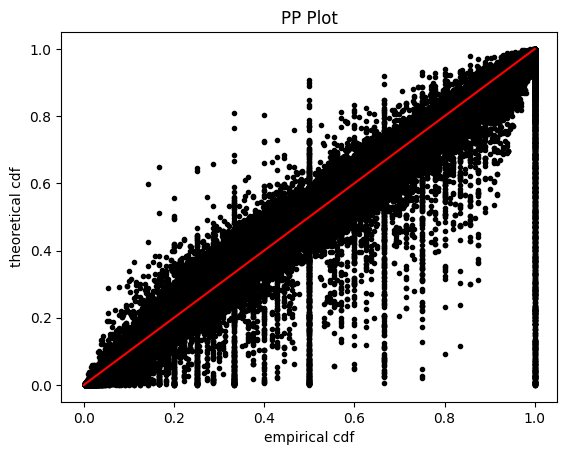

In [30]:
pp_plot(train)

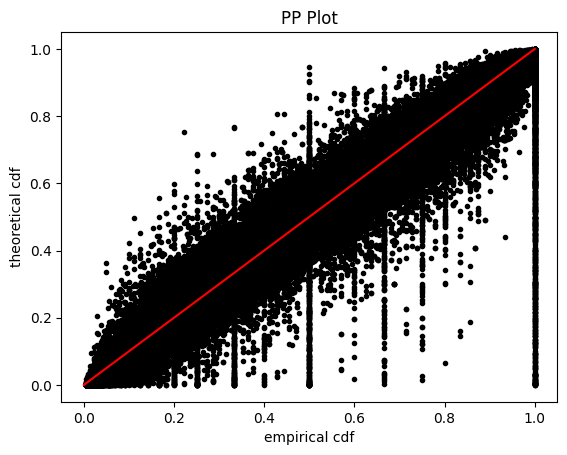

In [31]:
pp_plot(test)

### **Individual Hitters**

In [32]:
all_data = pd.concat((train, test))
lowe = all_data.loc[all_data.batter == 663993]
gallo = all_data.loc[all_data.batter == 608336]
chas = all_data.loc[all_data.batter == 676801]
breg = all_data.loc[all_data.batter == 608324]
yandy = all_data.loc[all_data.batter == 650490]

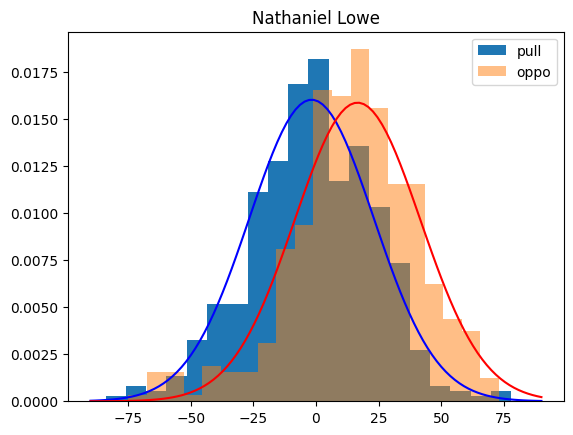

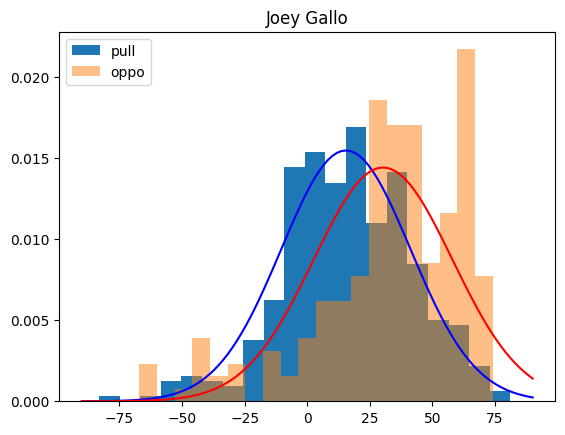

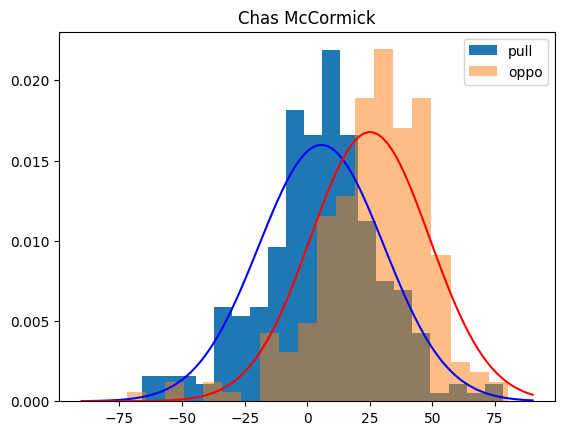

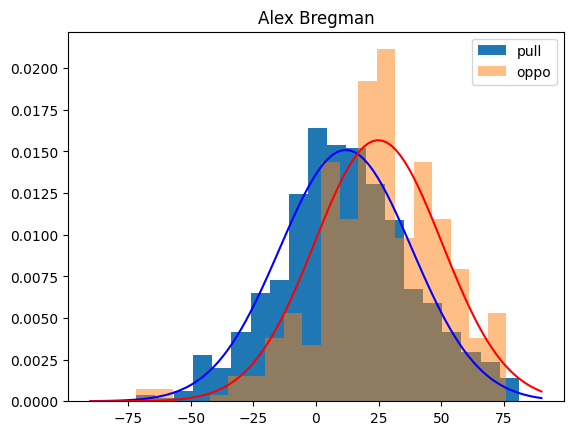

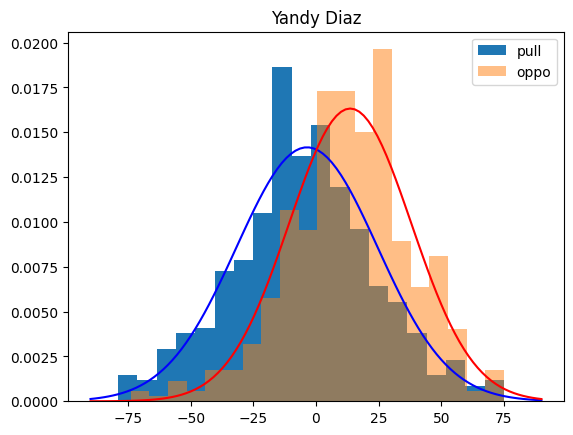

In [34]:
x = np.linspace(-90,90,100)
plt.hist(lowe.loc[lowe.is_pull == 1].launch_angle.values, density = True, bins=20, label = 'pull')
plt.hist(lowe.loc[lowe.is_pull == 0].launch_angle.values, density = True, bins=20, alpha = 0.5, label = 'oppo')
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b-')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r-')
plt.title('Nathaniel Lowe')
plt.legend()
plt.show()

plt.hist(gallo.loc[gallo.is_pull == 1].launch_angle.values, density = True, bins=20, label = 'pull')
plt.hist(gallo.loc[gallo.is_pull == 0].launch_angle.values, density = True, bins=20, alpha = 0.5, label = 'oppo')
plt.plot(x, norm(loc = gallo.batter_mean_pull.values[0], scale = gallo.batter_sigma_pull.values[0]).pdf(x), 'b-')
plt.plot(x, norm(loc = gallo.batter_mean_oppo.values[0], scale = gallo.batter_sigma_oppo.values[0]).pdf(x), 'r-')
plt.title('Joey Gallo')
plt.legend()
plt.show()

plt.hist(chas.loc[chas.is_pull == 1].launch_angle.values, density = True, bins=20, label = 'pull')
plt.hist(chas.loc[chas.is_pull == 0].launch_angle.values, density = True, bins=20, alpha = 0.5, label = 'oppo')
plt.plot(x, norm(loc = chas.batter_mean_pull.values[0], scale = chas.batter_sigma_pull.values[0]).pdf(x), 'b-')
plt.plot(x, norm(loc = chas.batter_mean_oppo.values[0], scale = chas.batter_sigma_oppo.values[0]).pdf(x), 'r-')
plt.title('Chas McCormick')
plt.legend()
plt.show()

plt.hist(breg.loc[breg.is_pull == 1].launch_angle.values, density = True, bins=20, label = 'pull')
plt.hist(breg.loc[breg.is_pull == 0].launch_angle.values, density = True, bins=20, alpha = 0.5, label = 'oppo')
plt.plot(x, norm(loc = breg.batter_mean_pull.values[0], scale = breg.batter_sigma_pull.values[0]).pdf(x), 'b-')
plt.plot(x, norm(loc = breg.batter_mean_oppo.values[0], scale = breg.batter_sigma_oppo.values[0]).pdf(x), 'r-')
plt.title('Alex Bregman')
plt.legend()
plt.show()

plt.hist(yandy.loc[yandy.is_pull == 1].launch_angle.values, density = True, bins=20, label = 'pull')
plt.hist(yandy.loc[yandy.is_pull == 0].launch_angle.values, density = True, bins=20, alpha = 0.5, label = 'oppo')
plt.plot(x, norm(loc = yandy.batter_mean_pull.values[0], scale = yandy.batter_sigma_pull.values[0]).pdf(x), 'b-')
plt.plot(x, norm(loc = yandy.batter_mean_oppo.values[0], scale = yandy.batter_sigma_oppo.values[0]).pdf(x), 'r-')
plt.title('Yandy Diaz')
plt.legend()
plt.show()

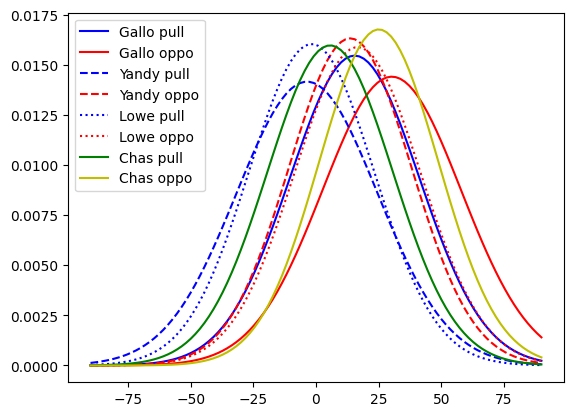

In [37]:
plt.plot(x, norm(loc = gallo.batter_mean_pull.values[0], scale = gallo.batter_sigma_pull.values[0]).pdf(x), 'b-', label = 'Gallo pull')
plt.plot(x, norm(loc = gallo.batter_mean_oppo.values[0], scale = gallo.batter_sigma_oppo.values[0]).pdf(x), 'r-', label = 'Gallo oppo')
plt.plot(x, norm(loc = yandy.batter_mean_pull.values[0], scale = yandy.batter_sigma_pull.values[0]).pdf(x), 'b--', label = 'Yandy pull')
plt.plot(x, norm(loc = yandy.batter_mean_oppo.values[0], scale = yandy.batter_sigma_oppo.values[0]).pdf(x), 'r--', label = 'Yandy oppo')
plt.plot(x, norm(loc = lowe.batter_mean_pull.values[0], scale = lowe.batter_sigma_pull.values[0]).pdf(x), 'b:', label = 'Lowe pull')
plt.plot(x, norm(loc = lowe.batter_mean_oppo.values[0], scale = lowe.batter_sigma_oppo.values[0]).pdf(x), 'r:', label = 'Lowe oppo')
plt.plot(x, norm(loc = chas.batter_mean_pull.values[0], scale = chas.batter_sigma_pull.values[0]).pdf(x), 'g-', label = 'Chas pull')
plt.plot(x, norm(loc = chas.batter_mean_oppo.values[0], scale = chas.batter_sigma_oppo.values[0]).pdf(x), 'y-', label = 'Chas oppo')
plt.legend()
plt.show()